# Titanic dataset

In this notebook, I analyse the Titanic dataset published in the [OpenML repository](https://www.openml.org/d/40945). 

The typical task with this dataset is to predict the chance of survival in the famous Titanic disaster. Here, I analyse the dataset in order to determine what factors were associated with the survival probability on the Titanic. 

### Attribute description
1. survived - Survival (0 = No; 1 = Yes)
2. pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
3. name - Name
4. sex - Sex
5. age - Age
6. sibsp - Number of Siblings/Spouses Aboard
7. parch - Number of Parents/Children Aboard
8. ticket - Ticket Number
9. fare - Passenger Fare
10. cabin - Cabin
11. embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = 12. Southampton)
12. boat - Lifeboat
13. body - Body number (if did not survive and body was recovered)
14. home.dest - Hometown

### Import libraries

Run the following cell to import the required libraries and define some parameters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import balanced_accuracy_score, make_scorer
from importlib import reload
import utils
reload(utils)
from utils import *
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from IPython.display import display

# set some plotting parameters
plt.rcParams.update({
    'font.size': 15,
    'axes.titlesize': 'medium'})
figsize = (10,3.5)
xlimits_bar = [-1,2]
xlimits_box = [0,3]
bar_width = .5

# utility function to convert from string to float, which handles missing 
# values as NaNs
nan_float = lambda data: np.array([np.nan if x=='?' else float(x) for x in data])

Run the following cell to open an ipython console. I find it handy when working with jupyter notebooks.

In [2]:
# Open the ipython console
%qtconsole --JupyterWidget.font_size=11

## 1 - Data processing and visualization

### Download the dataset

Run the next cell to download the dataset.

In [3]:
# load dataset
data_path = 'https://www.openml.org/data/get_csv/16826755/phpMYEkMl'
data = pd.read_csv(data_path)

data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


### Attribute selection

The next cell performs the following operations:
- selects relevant features (we leave out: name, cabin, embarked, body, home.dest)
- converts categorical features into binary arrays
        -- 'survived': 0 = didn't survive, 1 = survived
        -- 'boat': 0 = off lifeboat, 1 = on lifeboat
        -- 'sex': 0 = 'male', 1 = 'female'

In [4]:
# extract relevant data attributes
features = {
    'survived': 1.*data['survived'].to_numpy(), # 0 = didn't survive, 1 = survived
    'boat': 1.*(data['boat'].to_numpy()!='?'), # 0 = didn't board a lifeboat, 1 = boarded a lifeboat 
    'sex': 1.*(data['sex'].to_numpy()=='female'), # 0 = 'male', 1 = 'female'
    'pclass': data['pclass'].to_numpy(),
    'age': nan_float(data['age']),
    'sibsp': data['sibsp'].to_numpy(),
    'parch': data['parch'].to_numpy(),
    'fare': nan_float(data['fare'])
    }

# prettier names for (some) features
feat_pretty = {
    'survived': 'survived',
    'boat': 'lifeboat',
    'sex': 'sex',
    'pclass': 'class',
    'age': 'age',
    'sibsp': 'sib/sp',
    'parch': 'par/ch',
    'fare': 'fare'}

# number of examples
m = len(data)

# print some quick information about the dataset
print('Dataset size: %d' % m)
print('Number of survivors: %d (%.2f %%)' % \
      (np.sum(features['survived']), 100*np.sum(features['survived'])/m))
print('Number of people who boarded a lifeboat: %d (%.2f %%)' % \
      (np.sum(features['boat']), 100*np.sum(features['boat'])/m))
print('Survivors on lifeboats: %d (%.2f %%)' % \
       (np.sum(1.*np.logical_and(features['survived'],features['boat'])),
        100*np.sum(1.*np.logical_and(features['survived'],features['boat']))/np.sum(features['boat'])))
print('Survivors off lifeboats: %d (%.2f %%)' % \
       (np.sum(1.*np.logical_and(features['survived'],np.logical_not(features['boat']))),
        100*np.sum(1.*np.logical_and(features['survived'],np.logical_not(features['boat'])))/np.sum(np.logical_not(features['boat']))))

# show the count of missing values per feature
print('\n# of missing values:')
print(*[key+': %d'%(np.sum(np.isnan(value))) for key,value in features.items()], sep="\n")

Dataset size: 1309
Number of survivors: 500 (38.20 %)
Number of people who boarded a lifeboat: 486 (37.13 %)
Survivors on lifeboats: 477 (98.15 %)
Survivors off lifeboats: 23 (2.79 %)

# of missing values:
survived: 0
boat: 0
sex: 0
pclass: 0
age: 263
sibsp: 0
parch: 0
fare: 1


### Attribute distributions

First, let's plot the histograms for all the selected attributes.

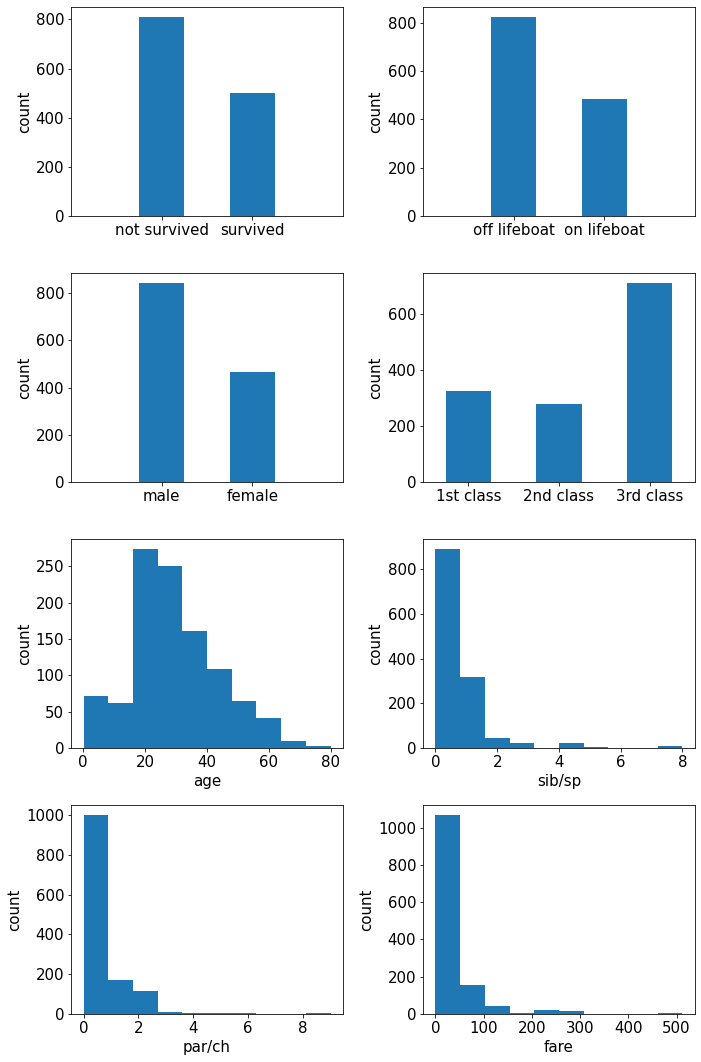

In [5]:
# show feature histograms
plt.figure(figsize=(10,15))
for k,item in enumerate(features.items()):
    plt.subplot(4,2,k+1)
    if item[0]=='survived':
        labels, counts = np.unique(item[1], return_counts=True)
        plt.bar(labels, counts, align='center', width=bar_width)
        plt.xticks(ticks=labels, labels=['not survived','survived'])
        plt.xlim((-1,2))
    elif item[0]=='boat':
        labels, counts = np.unique(item[1], return_counts=True)
        plt.bar(labels, counts, align='center', width=bar_width)
        plt.xticks(ticks=labels, labels=['off lifeboat','on lifeboat'])
        plt.xlim((-1,2))
    elif item[0]=='sex':
        labels, counts = np.unique(item[1], return_counts=True)
        plt.bar(labels, counts, align='center', width=bar_width)
        plt.xticks(ticks=labels, labels=['male','female'])
        plt.xlim((-1,2))
    elif item[0]=='pclass':
        labels, counts = np.unique(item[1], return_counts=True)
        plt.bar(labels, counts, align='center', width=bar_width)
        plt.xticks(ticks=labels, labels=['1st class','2nd class', '3rd class'])
        plt.xlim((.5,3.5))
    else:
        plt.hist(item[1])
        plt.xlabel(feat_pretty[item[0]])
    plt.ylabel('count')   
plt.tight_layout()

Some observations from the histograms above:
- the dataset is imbalanced with respect to the attribute 'survived' (the people who didn't make it are a lot more than those who survived)
- the number of survivors is almost equal to the number of people who boarded a lifeboat
- the majority of people were men
- the majority of people were in the 3rd class

### Attribute distributions with respect to 'survived'

The next cell plots the distribution of the various attributes for the 'not survived' and 'survived' groups.

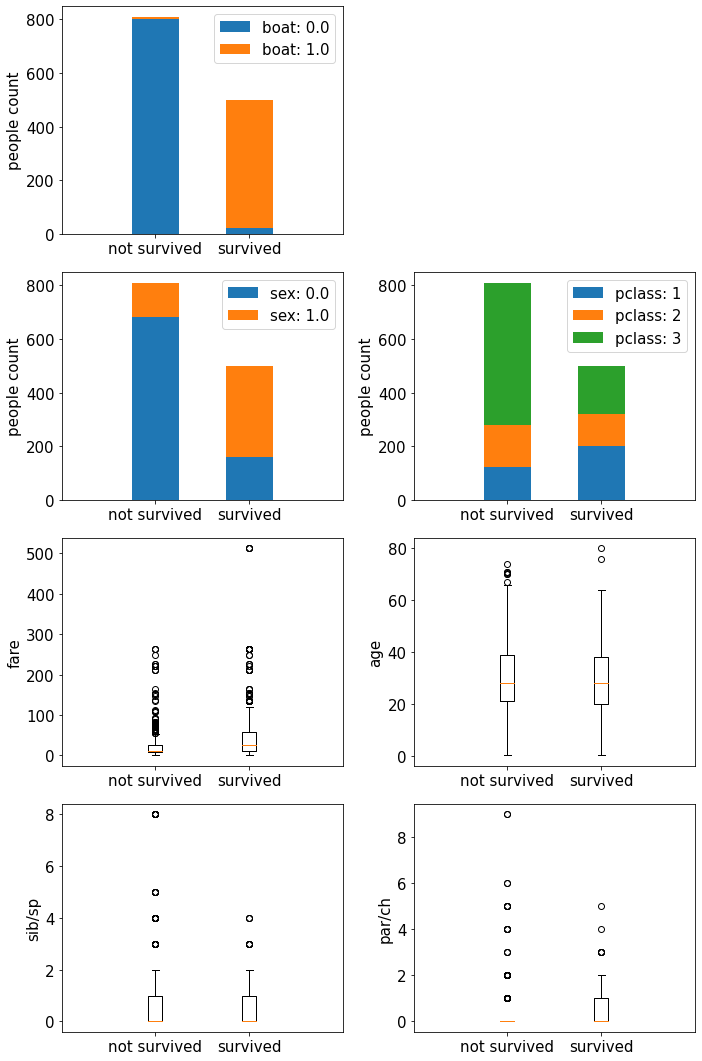

In [6]:
group = 'survived'
group_labels = ['not survived', 'survived']
feat_list = ['boat','sex','pclass','fare','age','sibsp','parch']
plot_type = [*['bar']*3, *['box']*4]
plot_idx = [1,*np.arange(3,9)]
nfeat = len(feat_list)
nrows = int(np.ceil(nfeat/2))
ncols = 2

plt.figure(figsize=(10,nrows*3.75))
for k,feat in enumerate(feat_list):
    if plot_type[k]=='bar':
        feat_values = np.unique(features[feat])
        bottom = 0
        plt.subplot(nrows,ncols,plot_idx[k])
        for val in feat_values:
            labels, counts = np.unique(features[group][features[feat]==val], return_counts=True)
            plt.bar(labels, counts, align='center', bottom = bottom, width=bar_width)
            bottom += counts
            plt.xticks(ticks=labels, labels=group_labels)
            plt.ylabel('people count')
            plt.xlim(xlimits_bar)
            plt.legend([feat + ': ' + str(val) for val in feat_values]);
    elif plot_type[k]=='box':
        plt.subplot(nrows,ncols,plot_idx[k])
        x = features[feat]
        y = features[group][~np.isnan(x)]
        x = x[~np.isnan(x)]
        plt.boxplot([x[y==ycurr] for ycurr in np.unique(y)], labels=group_labels)
        plt.xlim(xlimits_box)
        plt.ylabel(feat_pretty[feat]);

plt.tight_layout();

Some observations from the figure above:
- the majority of survivors were on lifeboat (not surprising). It is also possible that the 23 survivors off lifeboats DID actually board a lifeboat which is just uknown (missing value)
- most deaths were amongst men
- most deaths were in the 3rd class
- the group of survivors had paid a higher fare
- the group of survivors had a larger number of parents/children
- most people that did not survive had no parents/children 

### Attribute distributions with respect to 'boat'

The next cell plots the distribution of the various attributes for the 'off lifeboat' and 'on lifeboat' groups.

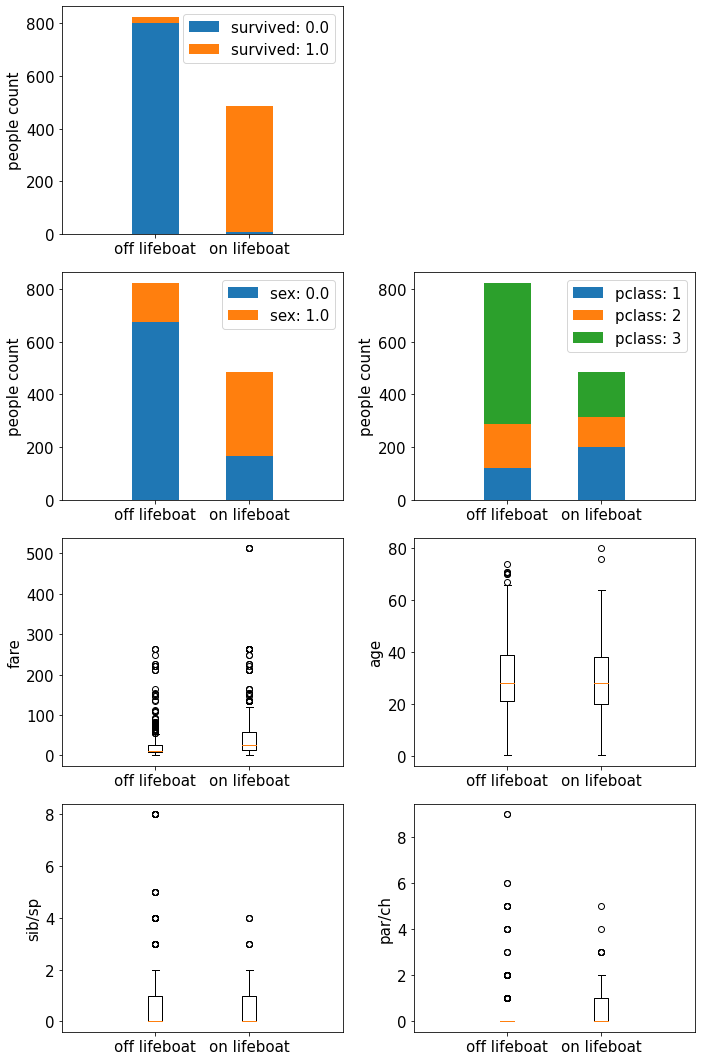

In [8]:
group = 'boat'
group_labels = ['off lifeboat', 'on lifeboat']
feat_list = ['survived','sex','pclass','fare','age','sibsp','parch']
plot_type = [*['bar']*3, *['box']*4]
plot_idx = [1,*np.arange(3,9)]
nfeat = len(feat_list)
nrows = int(np.ceil(nfeat/2))
ncols = 2

plt.figure(figsize=(10,nrows*3.75))
for k,feat in enumerate(feat_list):
    if plot_type[k]=='bar':
        feat_values = np.unique(features[feat])
        bottom = 0
        plt.subplot(nrows,ncols,plot_idx[k])
        for val in feat_values:
            labels, counts = np.unique(features[group][features[feat]==val], return_counts=True)
            plt.bar(labels, counts, align='center', bottom = bottom, width=bar_width)
            bottom += counts
            plt.xticks(ticks=labels, labels=group_labels)
            plt.ylabel('people count')
            plt.xlim(xlimits_bar)
            plt.legend([feat + ': ' + str(val) for val in feat_values]);
    elif plot_type[k]=='box':
        plt.subplot(nrows,ncols,plot_idx[k])
        x = features[feat]
        y = features[group][~np.isnan(x)]
        x = x[~np.isnan(x)]
        plt.boxplot([x[y==ycurr] for ycurr in np.unique(y)], labels=group_labels)
        plt.xlim(xlimits_box)
        plt.ylabel(feat_pretty[feat]);

plt.tight_layout();

In the figure above, we see that the distribution of the various attributes with respect to 'boat' is basically the same to what shown in the previous figure with respect to 'survived'. Having boarded a lifeboat is obviously a really good predictor of survival. Some further interesting observations:
- the majority of people on lifeboats were women
- the majority of people off lifeboats were man
- the majority of people off lifeboats were in the 3rd class
- people on lifeboats had paid a higher fare
- people on lifeboats had a larger number of parents/children
- most people off lifeboats had no parents/children 

### Attribute distributions with respect to 'pclass'

Now let's see the distribution of the various attributes with respect to the passenger class.

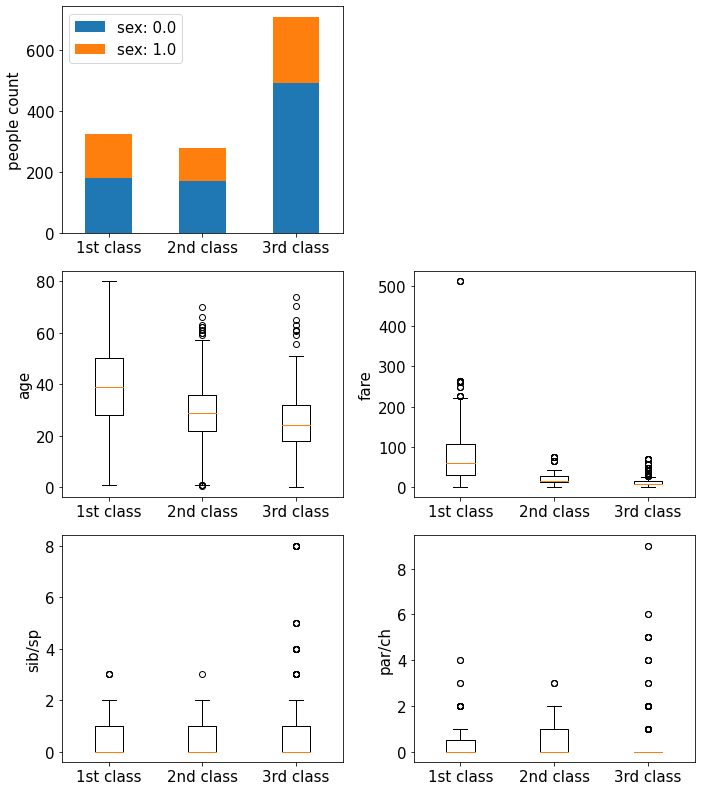

In [9]:
group = 'pclass'
group_labels = ['1st class', '2nd class', '3rd class']
feat_list = ['sex','age','fare','sibsp','parch']
plot_type = ['bar', *['box']*4]
plot_idx = [1,*np.arange(3,9)]
nfeat = len(feat_list)
nrows = int(np.ceil(nfeat/2))
ncols = 2
xlimits = (.5,3.5)

plt.figure(figsize=(10,nrows*3.75))
for k,feat in enumerate(feat_list):
    if plot_type[k]=='bar':
        feat_values = np.unique(features[feat])
        bottom = 0
        plt.subplot(nrows,ncols,plot_idx[k])
        for val in feat_values:
            labels, counts = np.unique(features[group][features[feat]==val], return_counts=True)
            plt.bar(labels, counts, align='center', bottom = bottom, width=bar_width)
            bottom += counts
            plt.xticks(ticks=labels, labels=group_labels)
            plt.ylabel('people count')
            plt.xlim(xlimits)
            plt.legend([feat + ': ' + str(val) for val in feat_values]);
    elif plot_type[k]=='box':
        plt.subplot(nrows,ncols,plot_idx[k])
        x = features[feat]
        y = features[group][~np.isnan(x)]
        x = x[~np.isnan(x)]
        plt.boxplot([x[y==ycurr] for ycurr in np.unique(y)], labels=group_labels)
        plt.xlim(xlimits)
        plt.ylabel(feat_pretty[feat]);

plt.tight_layout();

Some observations from the figure above:
- the ratio of female/male decreases with passenger class
- age and fare decrease with passenger class (fare is obvious)
- in the 3rd class, the majority of people had no parents/children

### Attribute distributions with respect to 'sex'

Now let's see how the various attributes are distributed with respect to the gender.

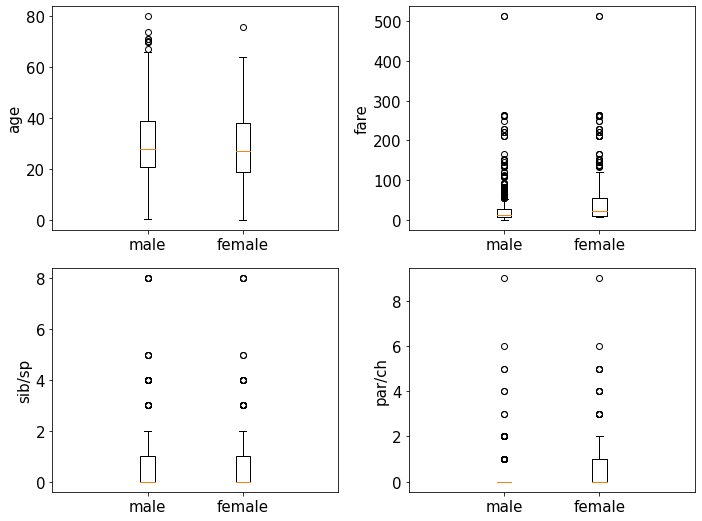

In [10]:
group = 'sex'
group_labels = ['male','female']
feat_list = ['age','fare','sibsp','parch']
plot_type = [*['box']*4]
plot_idx = np.arange(4)+1
nfeat = len(feat_list)
nrows = int(np.ceil(nfeat/2))
ncols = 2
xlimits = xlimits_box

plt.figure(figsize=(10,nrows*3.75))
for k,feat in enumerate(feat_list):
    if plot_type[k]=='bar':
        feat_values = np.unique(features[feat])
        bottom = 0
        plt.subplot(nrows,ncols,plot_idx[k])
        for val in feat_values:
            labels, counts = np.unique(features[group][features[feat]==val], return_counts=True)
            plt.bar(labels, counts, align='center', bottom = bottom, width=bar_width)
            bottom += counts
            plt.xticks(ticks=labels, labels=group_labels)
            plt.ylabel('people count')
            plt.xlim(xlimits)
            plt.legend([feat + ': ' + str(val) for val in feat_values]);
    elif plot_type[k]=='box':
        plt.subplot(nrows,ncols,plot_idx[k])
        x = features[feat]
        y = features[group][~np.isnan(x)]
        x = x[~np.isnan(x)]
        plt.boxplot([x[y==ycurr] for ycurr in np.unique(y)], labels=group_labels)
        plt.xlim(xlimits)
        plt.ylabel(feat_pretty[feat]);

plt.tight_layout();

From the figure above we see that:
- women tended to pay a higher fare than man
- women had a larger number of parents/children than men

## 2 - Correlation between attributes

We now calculate the correlation between all pairs of attributes. The next cell performs the following operations:
- computes the Spearman's correlation coefficient between any pair of attributes
- it estimates the confidence intervals of each correlation coefficient by bootstrapping
- it calculates the p-value of each correlation coefficient and applies Bonferroni correction for multiple comparisons

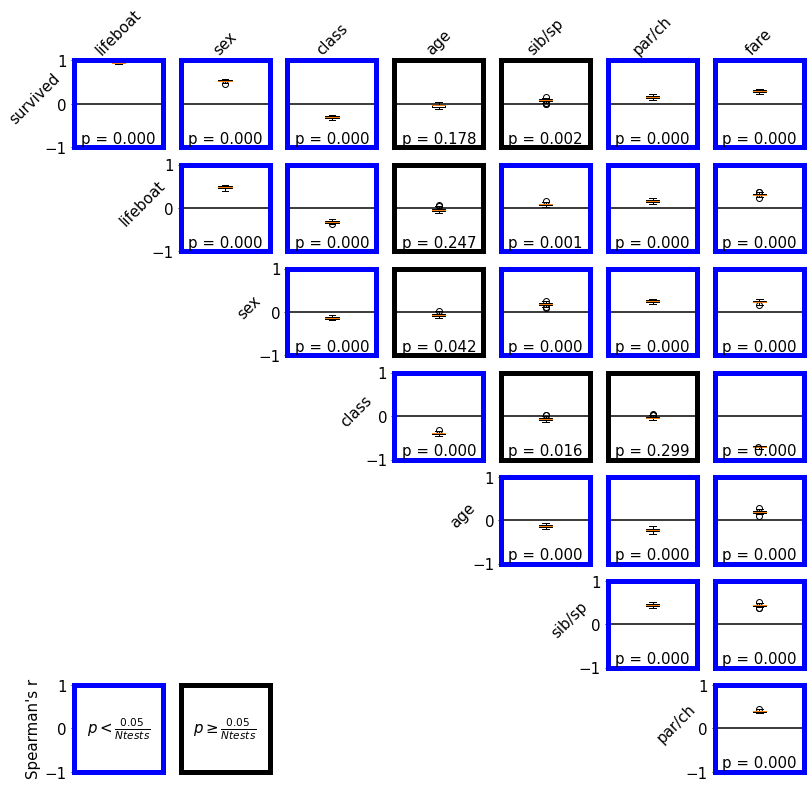

In [11]:
# show the correlation coefficient across features
nfeat = len(features)
pcount = 1
ntests = (nfeat**2 - nfeat)/2
stat_fun = spearmanr
plt.rc('axes', edgecolor='black', linewidth=5)

plt.figure(figsize=(15,15))
for i,item_i in enumerate(features.items()):
    for j,item_j in enumerate(features.items()):
        if j>i:
            # compute correlation distribution by bootstrapping
            r,r_av,r_ci = bootstrap(nan_reject([item_i[1], item_j[1]], match_list=True), 
                          stat_fun, 100)
            
            # compute p-values 
            _,p = stat_fun(*nan_reject([item_i[1], item_j[1]], match_list=True))
            
            # highlight the significant p-values (bonferroni corrected) in blue
            if p<.05/ntests:
                plt.rc('axes', edgecolor='blue')
            else:
                plt.rc('axes', edgecolor='black')
            
            plt.subplot(nfeat,nfeat,pcount)
            #plt.scatter(0, r_av)
            #plt.vlines(0, r_ci[0], r_ci[1])
            plt.boxplot(r)
            plt.hlines(0, *plt.xlim(), color='k')
            plt.text(plt.xlim()[0] + .5*np.diff(plt.xlim()),-.9,'p = %.3f'%p,
                    horizontalalignment='center')
            plt.xticks(ticks=[])
            plt.ylim((-1,1))
            if i==0: plt.title(feat_pretty[item_j[0]], rotation=45)
            if j==i+1: plt.ylabel(feat_pretty[item_i[0]], rotation=45)
            if j!=i+1: plt.yticks(ticks=[])
        
        pcount += 1

# legend
plt.rc('axes', edgecolor='blue')
plot_pos = (nfeat-1)**2+1#int(nfeat*nfeat*.67)
plt.subplot(nfeat,nfeat,plot_pos)
plt.ylim((-1,1))
plt.xlim((-1,1))
plt.xticks(ticks=[])
plt.ylabel('Spearman\'s r')
plt.text(0, 0, r'$p < \frac{0.05}{Ntests}$', horizontalalignment='center', verticalalignment='center')
plt.rc('axes', edgecolor='black')
plt.subplot(nfeat,nfeat,plot_pos+1)
plt.ylim((-1,1))
plt.xlim((-1,1))
plt.yticks(ticks=[])
plt.xticks(ticks=[])
plt.text(0, 0, r'$p \geq \frac{0.05}{Ntests}$', horizontalalignment='center', verticalalignment='center')


plt.rc('axes', edgecolor='black', linewidth=1)

The figure above condenses all the observations drawn from the previous plots:
- 'survived' positively correlates with 'boat', 'sex', 'par/ch' and 'fare', while it negatively correlates with passenger class
- 'boat' (lifeboat) exhibits almost the same correlations as 'survived'
- 'sex' positively correalates with 'sib/sp', 'par/ch' and 'fare', while it negatively correlates with passenger class
- 'class' (passenger class) inversely correlates with 'age' and 'fare' 

In addition:
- 'age' negatively correlates with 'sib/sp' and 'par/ch', while it positively correlates with 'fare'
- 'sib/sp' positively correlates with 'par/ch' and 'fare'
- 'par/ch' positively correlates with 'fare'

## 3 - Logistic regression (using scikit-learn)

The correlation analysis suggests that several factors may be associated with the survival probability. However, due to the significant correlations between the factors themselves, this analysis is not sufficient to determine what factors are actually associated with survival probability. 

We need an approach that can deal with inter-factor correlations and highlight only those factors that are actually correlated with survival probability. Multiple logistic regression can do exactly this, by fitting a logistic model to predict the survival probability from a linear combination of all factors. 

In this section I perform logistic regression using `scikit-learn` and a machine learning approach.

### Processing pipeline

The next cell specifies the processing pipeline, which consists of:
- standardization of non-categorical features
- fitting a logistic model, using class weights to compensate for the imbalanced labels ('survived')
- the model is fit on 50% of the data and tested on the other 50%
- cross-validation is performed using 100 random splits
- balanced accuracy is used to assess model performance

In [12]:
def standardize(X_keys, cat_list=['boat','sex']):
    '''
    
    Feature standardization routine. 
    
    '''
    is_categorical = ismember(X_keys, cat_list)
    if all(is_categorical):
        return StandardScaler(with_mean=False, with_std=False)
    elif not any(is_categorical):
        return StandardScaler()
    else:
        return ColumnTransformer([
            ('cat', StandardScaler(with_mean=False, with_std=False), is_categorical),
            ('noncat', StandardScaler(), np.logical_not(is_categorical))])

def cross_validate_logit(X, Y, X_keys, verbose=False):
    '''
    
    Routine to cross-validate the logistic regression model.
    
    '''
    
    # specify logistic regression model
    logit = LogisticRegression(penalty='l2', 
                               solver='liblinear', 
                               class_weight='balanced')

    # specify processing pipeline
    pipeline = make_pipeline(standardize(X_keys), 
                             logit)

    # specify cross-validation iterator
    shuffle_split = ShuffleSplit(n_splits=100, 
                                 test_size=.5, 
                                 random_state=0)
    
    # reject remaining examples with missing values
    sel_idx = np.squeeze(np.argwhere(np.sum(np.isnan(X),axis=1)==0))
    Y = Y[sel_idx]
    X = X[sel_idx,:]

    # print number of features and examples
    if verbose:
        m,n = np.shape(X)
        print('# of examples: %d' % m)
        print('# of features: %d' % n)
        print('features: %s' % X_keys)
        print('survival rate: %.2f' % (np.sum(Y)/len(Y)))
    
    # perform crossvalidation
    cv_result = cross_validate(pipeline, X, Y, 
                               return_train_score=True, 
                               return_estimator=True,
                               cv=shuffle_split, 
                               scoring=make_scorer(balanced_accuracy_score))
    
    return cv_result

### Results - Model including all factors

First, we fit a logistic model considering all factors, except 'boat' (which is just a boringly obvious predictor of survival probability, as we have established in the previous analysis). 

# of examples: 1045
# of features: 6
features: ['sex', 'pclass', 'age', 'sibsp', 'parch', 'fare']
survival rate: 0.41


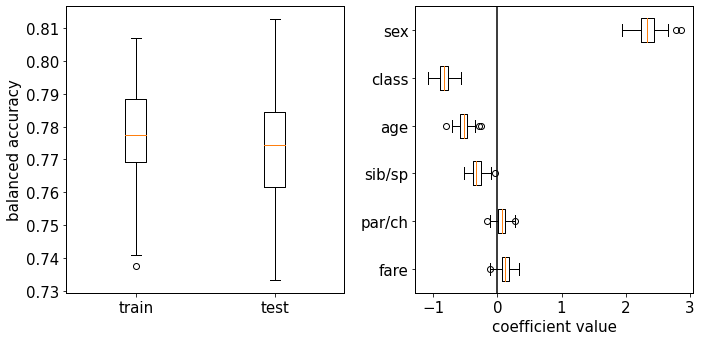

In [13]:
# variable to predict
Y = features['survived']

# feature selection
X_keys = ['sex','pclass','age','sibsp','parch','fare']
X = np.column_stack([features[key] for key in X_keys])

# cross-validate logistic regression model
cv_result = cross_validate_logit(X, Y, X_keys, verbose=True)

# extract model coefficients
cv_coef = np.concatenate(
    [x.steps[1][1].coef_ for x in cv_result['estimator']], axis=0)

# plot
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot([cv_result['train_score'], cv_result['test_score']], \
           labels=['train', 'test'])
plt.ylabel('balanced accuracy')
plt.subplot(122)
plt.boxplot(cv_coef, 
            labels=[feat_pretty[key] for key in X_keys], 
            vert=False, positions=np.flip(np.arange(len(X_keys))))
plt.xlabel('coefficient value')
plt.vlines(0, *plt.ylim(), color='k')
plt.tight_layout();

We see that this model achieves an average prediction accuracy of about 78%. In addition, looking at the fitting coefficients we see that:
- survival probability is positively associated with 'sex', meaning that women were indeed more likely to survive 
- survival probability is negatively associated with passenger 'class', 'age', as well as number of siblings/spouses ('sib/sp')
- this analysis highlights an effect of 'age' and 'sib/sp' which were not captured by the correlation analysis
- 'par/ch' and 'fare' have a relatively weak effect, suggesting that their effect in the correlation analysis was probably a result of their correlation with other attributes (such as 'class', 'sex', 'age', 'sib/ch')

### Results - Model including single factors

In order to highlight the difference between using all factors simultaneously (as done above) and using them separately (as done in the correlation analysis), we now fit a separate logistic model for each factor. 

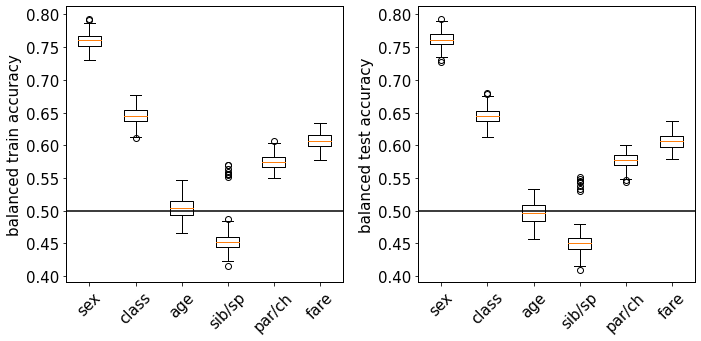

In [14]:
feat_to_predict = 'survived'
X_keys_list = ['sex','pclass','age','sibsp','parch','fare']

test_scores = []
train_scores = []
for curr_key in X_keys_list:
    # variable to predict
    Y = features[feat_to_predict]
    
    # feature selection
    X_keys = [curr_key]
    X = np.column_stack([features[key] for key in X_keys])

    # cross-validate logistic regression model
    cv_result = cross_validate_logit(X, Y, X_keys)
    
    # append test scores
    test_scores.append(cv_result['test_score'])
    train_scores.append(cv_result['train_score'])

# plot
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.boxplot(train_scores, labels=[feat_pretty[key] for key in X_keys_list])
plt.xticks(rotation=45)
Y = features[feat_to_predict]
plt.hlines(.5, plt.xlim()[0], plt.xlim()[1], color='k')
plt.ylabel('balanced train accuracy');
plt.subplot(122, sharey=ax1)
plt.boxplot(test_scores, labels=[feat_pretty[key] for key in X_keys_list])
plt.xticks(rotation=45)
Y = features[feat_to_predict]
plt.hlines(.5, plt.xlim()[0], plt.xlim()[1], color='k')
plt.ylabel('balanced test accuracy')
plt.tight_layout();

As we can see, the predictive performance of each factor taken singularly is just a reflection of its correlation with survival. This approach can lead to misleading results. For example, based on this approach (or equivalently, based on the correlation analysis), it would appear that survival probability is not associated with 'age'. However, the logistic model which includes all factors together, suggest that 'age' is indeed an important factor for predicting survival.

### Results - Comparison between multiple models

In order to further validate the observations above, here we fit 8 different models, each with a different combination of factors (as specified in the dictionary `model_specs`). We start with including only 'sex' (model 1), which we have seen it is the best predictor of survival when taken singularly. We then add any combination of other 1 to 3 factors chosing from 'pclass', 'age' and 'sibsp'.

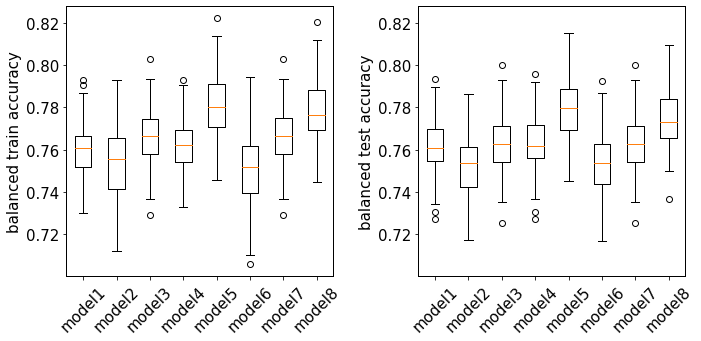

In [15]:
feat_to_predict = 'survived'
model_specs = {
    'model1': ['sex'],
    'model2': ['sex', 'pclass'],
    'model3': ['sex', 'age'],
    'model4': ['sex', 'sibsp'],
    'model5': ['sex', 'pclass', 'age'],
    'model6': ['sex', 'pclass', 'sibsp'],
    'model7': ['sex', 'age', 'sibsp'],
    'model8': ['sex', 'pclass', 'age','sibsp']}

train_scores = []
test_scores = []
for curr_key in model_specs.values():
    # variable to predict
    Y = features[feat_to_predict]
    
    # feature selection
    X_keys = curr_key
    X = np.column_stack([features[key] for key in X_keys])

    # cross-validate logistic regression model
    cv_result = cross_validate_logit(X, Y, X_keys)
    
    # append train/test scores
    train_scores.append(cv_result['train_score'])
    test_scores.append(cv_result['test_score'])

# plot
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.boxplot(train_scores, labels=model_specs.keys())
plt.xticks(rotation=45)
Y = features[feat_to_predict]
plt.ylabel('balanced train accuracy');
plt.subplot(122, sharey=ax1)
plt.boxplot(test_scores, labels=model_specs.keys())
plt.xticks(rotation=45)
Y = features[feat_to_predict]
plt.ylabel('balanced test accuracy');
plt.tight_layout();

We see that the model including 'sex', 'pclass' and 'age' (model5) performs slightly better than the other models, showing that these three factors taken together are the best predictors of survival.

## 4 - Logistic regression (using statsmodel)

In the previous section we have used logistic regression and a machine learning approach to identify the factors associated with survival, and we found them to be 'sex', 'pclass' and 'age', and to a weaker extent also 'sib/sp'. 

In this section we perform a complementary analysis following a statistical approach, whereby logistic regression is framed as a generalized linear model (GLM). This approach enables analytic calculation of confidence intervals on the coefficients, and it is therefore very convenient to investigate the association between factors and survival. 

### Model fitting

We use the `statsmodel` library, to fit 2 different logistic models:
- **model 1**: includes factors 'sex', 'pclass', 'age', 'sibsp', 'parch', 'fare'
- **model 2**: includes all factors of model 1, plus all interactions between pairs of factors which were found to be significantly correlated in the previous correlation analysis

In [20]:
# variable to predict
feat_to_predict = 'survived'
Y = features[feat_to_predict]

# feature selection
X_keys = ['boat','sex','pclass','age','sibsp','parch','fare']
X = np.column_stack([features[key] for key in X_keys])

# feature standardization
X = standardize(X_keys).fit(X).transform(X)

# create data frame
data_frame = pd.DataFrame(
    data = np.column_stack([Y,X]), 
    columns = [feat_to_predict]+X_keys)
display(data_frame.head())

# fit logistic regression model(s)
model_specs_list = [
    feat_to_predict + " ~ sex + pclass + age + sibsp + parch + fare",
    feat_to_predict + " ~ sex*pclass + sex*sibsp + sex*parch + sex*fare + age*pclass + age*sibsp + age*parch + age*fare + pclass*fare + sibsp*parch + sibsp*parch + parch*fare"]
models = []
results = []
for k,model_specs in enumerate(model_specs_list):
    models.append(
        sm.GLM.from_formula(model_specs, family=sm.families.Binomial(), data=data_frame))
    results.append(models[k].fit())

,survived,boat,sex,pclass,age,sibsp,parch,fare
0,1.0,1.0,1.0,-1.546098,-0.061162,-0.479087,-0.445000,3.441165
1,1.0,1.0,0.0,-1.546098,-2.010496,0.481288,1.866526,2.285603
2,0.0,0.0,1.0,-1.546098,-1.935302,0.481288,1.866526,2.285603
3,0.0,0.0,0.0,-1.546098,0.008251,0.481288,1.866526,2.285603
4,0.0,0.0,1.0,-1.546098,-0.338812,0.481288,1.866526,2.285603


### Results - Model 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               survived   No. Observations:                 1045
Model:                            GLM   Df Residuals:                     1038
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -485.19
Date:                Sun, 21 Feb 2021   Deviance:                       970.37
Time:                        11:52:26   Pearson chi2:                 1.08e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5396      0.110    -13.965      0.000      -1.756      -1.324
sex            2.5467      0.173     14.682      0.000       2.207       2.887
pclass        -0.9198      0.110     -8.364      0.000      -1.135      -0.704
age           -0.5534      0.094     -5.862      0.000      -0.738      -0.368
sibsp         -0.3694      0.110     -3.351      0.001      -0.585      -0.153
parch          0.0475      0.089      0.533      0.594      -0.127       0.222
fare           0.0849      0.098      0.865      0.387      -0.107       0.277
==============================================================================
"""

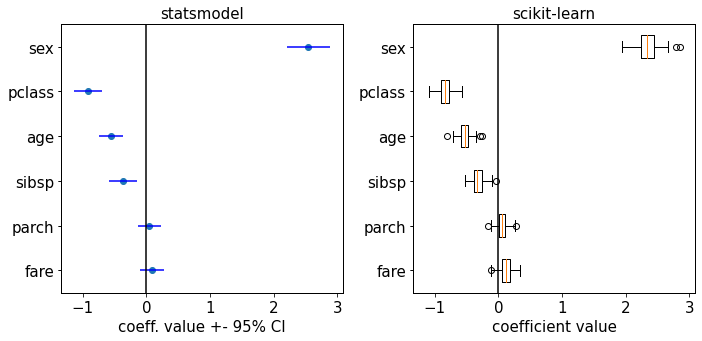

In [21]:
result = results[0]

display(result.summary())

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
av = result.params[1:]
err = result.conf_int()[1][1:] - av
pos = np.flip(np.arange(len(av)))
plt.errorbar(x=av, y=pos, xerr=err, fmt=' ', color='b')
plt.scatter(av, pos)
plt.yticks(ticks=pos, labels=result.params.index[1:])
plt.xlabel('coeff. value +- 95% CI')
plt.title('statsmodel');
ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
plt.boxplot(cv_coef, 
            labels=result.params.index[1:], 
            vert=False, positions=pos)
plt.xlabel('coefficient value')
plt.vlines(0, *plt.ylim(), color='k')
plt.title('scikit-learn')
plt.subplot(ax1)
plt.vlines(0,*plt.ylim(), color='k')
plt.tight_layout();


**Model 1** is equivalent to the model we fit using `scikit-learn` and cross-validation. Therefore, in the figure above we see that the estimated coefficients are basically the same. Again, we see that 'sex', 'pclass', 'age' and 'sibsp' are the significant factors.  

### Results - Model 2

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               survived   No. Observations:                 1045
Model:                            GLM   Df Residuals:                     1027
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -455.45
Date:                Sun, 21 Feb 2021   Deviance:                       910.89
Time:                        11:52:30   Pearson chi2:                 1.32e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.6626      0.237     -7.022      0.000      -2.127      -1.199
sex             2.6412      0.201     13.152      0.000       2.248       3.035
pclass         -0.7192      0.211     -3.416      0.001      -1.132      -0.307
sex:pclass     -1.3670      0.279     -4.903      0.000      -1.913      -0.821
sibsp          -0.0587      0.190     -0.309      0.758      -0.431       0.314
sex:sibsp      -0.1433      0.245     -0.586      0.558      -0.623       0.336
parch           0.3211      0.170      1.892      0.059      -0.012       0.654
sex:parch      -0.1106      0.214     -0.517      0.605      -0.530       0.309
fare           -0.6662      0.573     -1.163      0.245      -1.789       0.456
sex:fare       -0.1907      0.264     -0.721      0.471      -0.709       0.327
age            -0.5150      0.115     -4.495      0.000      -0.740      -0.290
age:pclass     -0.0720      0.125     -0.576      0.564      -0.317       0.173
age:sibsp       0.2621      0.139      1.888      0.059      -0.010       0.534
age:parch      -0.2801      0.114     -2.452      0.014      -0.504      -0.056
age:fare        0.0165      0.126      0.131      0.895      -0.230       0.263
pclass:fare    -0.4748      0.361     -1.314      0.189      -1.183       0.234
sibsp:parch    -0.1037      0.128     -0.807      0.420      -0.355       0.148
parch:fare     -0.0360      0.086     -0.416      0.677      -0.206       0.134
===============================================================================
"""

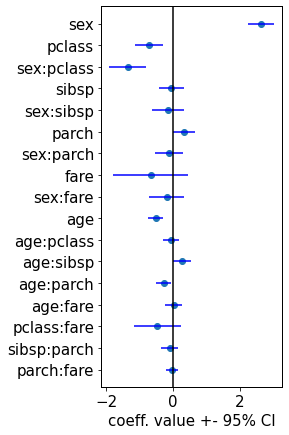

In [22]:
result = results[1]

display(result.summary())

plt.figure(figsize=(3.25,7))
av = result.params[1:]
err = result.conf_int()[1][1:] - av
pos = np.flip(np.arange(len(av)))
plt.errorbar(x=av, y=pos, xerr=err, fmt=' ', color='b')
plt.scatter(av, pos)
plt.yticks(ticks=pos, labels=result.params.index[1:])
plt.vlines(0,*plt.ylim(), color='k')
plt.autoscale(enable=True, axis='y', tight=True)
plt.xlabel('coeff. value +- 95% CI');

With **model 2** we explicitely investigate the effect of pairwise factor interactions on survival probability. This model shows the following:
- it confirms a significant effect of 'sex', 'pclass' and 'age'
- the effect of 'sibsp' disappears
- it additionally reveals a significant effect of the interaction 'sex:pclass' and 'age:parch'

### Results - Comparison between model 1 and 2

Here we perform a likelihood ratio test to compare model 1 and 2. 

In [23]:
likelihood_ratio_test(results[0], results[1]);

Likelihood ratio: 59.480
Degrees of freedom: 11
p-value: 1.157927416153964e-08


This test shows that model 2 fits the dataset significantly better than model 1, suggesting that the interaction terms should indeed be considered in order to better predict the survival rate. 

## 5 - Conclusions

Survival probability in the Titanic disaster was mostly associated with 'sex', 'age' and 'pclass'. In particular:
- women were more likely to survive than men
- younger passenger were more likely to survive than older ones
- passenger in 1st class were more likely to survive than passengers in 3rd class

These results fit the known emergency policy that was enforced by the Titanic's captain in order to decide who was going to board lifeboats or not, that is: ['women and children first'](https://en.wikipedia.org/wiki/Women_and_children_first). But it also shows that 1st class passengers received priority over other classes. 